In [73]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path,lap_eig_decay, diffusion_decay, eff_res_decay, eff_res_corr_decay
from utils.toydata_utils import get_toy_data
from utils.fig_utils import dist_to_color
from utils.dist_utils import compute_laplacian, get_sknn
import os
import matplotlib
import numpy as np
import scipy.sparse.linalg


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [68]:
style_file = "utils.style"
plt.style.use(style_file)
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Eigenvector decay fig

In [75]:
# get data
seed = 0
sigmas = [0.0, 0.1, 0.25]
n = 1000
d = 50
dataset = "toy_circle"

data = np.array([get_toy_data(dataset = dataset, n= n, d=d, seed=seed, **{"gaussian":{"sigma": sigma}}) for sigma in sigmas])

In [76]:
# get eigenvalues and eigenvectors
k = 15
n_evecs = 999
norms = ["sym"]  # only use symmetric normalization for the plot

evals = {}
evecs = {}
for norm in norms:
    evals_norm = {}
    evecs_norm = {}
    for i, data_sig in enumerate(data):
        sknn_coo = get_sknn(data_sig, k=k)

        L = compute_laplacian(sknn_coo, normalization=norm)

        # compute eigenvectors, following the setting in the UMAP code base
        eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(
                        L,
                        n_evecs,
                        which="SM",
                        tol=1e-4,
                        v0=np.ones(L.shape[0]),
                        maxiter=L.shape[0] * 5,
                    )
        evals_norm[sigmas[i]] = eigenvalues
        evecs_norm[sigmas[i]] = eigenvectors
        print(f"Done with norm {norm} and sigma {sigmas[i]}")
    evals[norm] = evals_norm
    evecs[norm] = evecs_norm

Done with norm sym and sigma 0.0
Done with norm sym and sigma 0.1
Done with norm sym and sigma 0.25


/tmp/ipykernel_52541/4002028326.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab20')


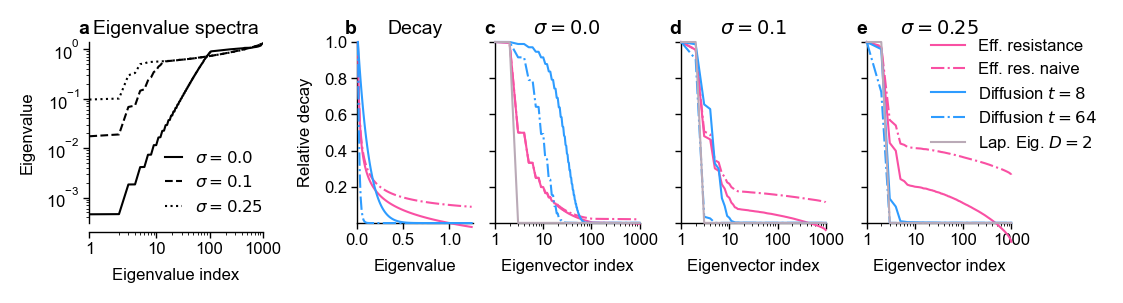

In [78]:
# plot figure
fig, ax = plt.subplots(ncols=5, width_ratios=(1.2, 0.8,1,1,1), figsize=(5.5, 1.4))


letters = "abcde"

# panel a with eigenvalues for different noise levels
linestyles = ["solid", "dashed", "dotted"]
for j, sigma in enumerate(sigmas):
    ax[0].plot(np.arange(1, 999), evals["sym"][sigma][1:], label=f"$\sigma = {sigma}$", c="k", linestyle=linestyles[j])
ax[0].legend(frameon=False, loc=(0.4, 0.01), handlelength=1.0)
ax[0].set_xscale("symlog")
ax[0].set_yscale("log")
ax[0].set_xlim(1, 1000)
ax[0].set_ylim(None, 1.4)
ax[0].spines['left'].set_position(('data', 1))
ax[0].spines['bottom'].set_position(('data', 0.0002))

ax[0].set_xticks([1, 10, 100, 1000])
ax[0].set_xticklabels([1, 10, 100, 1000])

ax[0].xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5,  0.6, 0.7, 0.8, 0.9)))
ax[0].set_title("Eigenvalue spectra")
ax[0].set_title(
    letters[0],
    ha="right",
    loc="left",
    fontweight="bold",
)
ax[0].set_ylabel("Eigenvalue")
ax[0].set_xlabel("Eigenvalue index")


cmap = matplotlib.cm.get_cmap('tab20')

# panel b with the eigenvector decay functions
n_xvals = 100
possible_evals = np.arange(1, 1.25* n_xvals) / n_xvals
ax[1].plot(possible_evals, eff_res_corr_decay(possible_evals), label="eff res corr", c=dist_to_color["eff_res"], zorder=10, clip_on=False)
ax[1].plot(possible_evals, eff_res_decay(possible_evals), label="eff res", c=dist_to_color["eff_res"], linestyle="dashdot", zorder=10, clip_on=False)
ax[1].plot(possible_evals, diffusion_decay(possible_evals, t=8), label="Diffusion t=8", c=dist_to_color["diffusion"], zorder=10, clip_on=False)
ax[1].plot(possible_evals, diffusion_decay(possible_evals, t=64), label="Diffusion t=64", c=dist_to_color["diffusion"], linestyle="dashdot", zorder=10, clip_on=False)

ax[1].set_xticks([0, 0.5, 1.0])
ax[1].set_ylim(0.001, 1)
ax[1].set_xlim(0, 1.25)

ax[1].spines['left'].set_position(('data', 0))
ax[1].spines['bottom'].set_position(('data', 0))

ax[1].set_xlabel("Eigenvalue")
ax[1].set_ylabel("Relative decay")
ax[1].set_title("Decay")
ax[1].set_title(
    letters[1],
    ha="right",
    loc="left",
    fontweight="bold",
)

# remaining panels with the decay of each eigenvector, one for each noise level
for i, sigma in enumerate([0.0, 0.1, 0.25]):
    i = i+2
    ax[i].plot(np.arange(1, 999), eff_res_corr_decay(evals["sym"][sigma][1:]), label="Eff. resistance", c=dist_to_color["eff_res"], clip_on=False, zorder =5)
    ax[i].plot(np.arange(1, 999), eff_res_decay(evals["sym"][sigma][1:]), label="Eff. res. naive", c=dist_to_color["eff_res"], clip_on=False, linestyle="dashdot", zorder =5)
    ax[i].plot(np.arange(1, 999), diffusion_decay(evals["sym"][sigma][1:], t=8), label="Diffusion $t = 8$", c=dist_to_color["diffusion"], clip_on=False, zorder =5)
    ax[i].plot(np.arange(1, 999), diffusion_decay(evals["sym"][sigma][1:], t=64), label="Diffusion $t = 64$", c=dist_to_color["diffusion"], clip_on=False, linestyle="dashdot", zorder =5)
    ax[i].plot(np.arange(1, 999), lap_eig_decay(evals["sym"][sigma][1:], n_evecs=2), label="Lap. Eig. $D=2$", c=dist_to_color["spectral"], clip_on=False, zorder =5)
    
    ax[i].set_xscale("log")
    ax[i].set_xscale("log")
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(1, 1000)
    
    ax[i].spines['left'].set_position(('data', 1))
    ax[i].spines['bottom'].set_position(('data', 0))

    if i != 0:
        ax[i].set_yticklabels([])
    ax[i].set_xlabel("Eigenvector index")
    ax[i].set_xticks([1, 10, 100, 1000])    
    ax[i].set_xticklabels([1, 10, 100, 1000], zorder=6)   
    if i == 4:
        ax[i].legend(frameon=False, loc=(0.4,0.35))
    ax[i].set_title(f"$\sigma = {sigma}$")
    ax[i].set_title(
    letters[i],
    ha="right",
    loc="left",
    fontweight="bold",
)
fig.savefig(os.path.join(fig_path, "fig_eig_decay_log.pdf"))